<h1 align='center'>Домашнее задание</h1>

**Дополнительный материал для выполнения дз**:

- Лекция Coursera: https://ru.coursera.org/learn/machine-learning/lecture/4BHEy/regularized-logistic-regression
- Статья на Хабре: https://habrahabr.ru/company/io/blog/265007/
- Книжка ISLR, 4 глава: http://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf
- Логистическая регрессия, UFLDL Tutorial: http://ufldl.stanford.edu/tutorial/supervised/LogisticRegression/
- Линейная регрессия, UFLDL Tutorial: http://ufldl.stanford.edu/tutorial/supervised/LinearRegression/


<h1 align='center'>Logistic Regression</h1>

In [10]:
import pandas as pd
import numpy as np
#import tqdm # interactive progress bar

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline

# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## 1. Знакомство с данными
Данные представляют собой выборку отзывов о еде с сайта Амазон. Для них проставлены метки -- положительный или отрицательный отзыв.

In [11]:
train_df = pd.read_csv('./data/train.csv')

In [12]:
print train_df.shape

(110163, 3)


In [13]:
train_df.head()

,ID,Reviews_Summary,Prediction
0,239071,Michigan Cherries,1
1,466160,Great Product,1
2,397133,Ovaltine,1
3,297146,~,1
4,292685,Love it!,1


In [14]:
train_df.Prediction.value_counts(normalize=True)

0    0.50074
1    0.49926
Name: Prediction, dtype: float64

Видим, что классы сбалансированы. Можем оценивать качество модели по метрике ```accuracy```.

In [15]:
train_df.head()

,ID,Reviews_Summary,Prediction
0,239071,Michigan Cherries,1
1,466160,Great Product,1
2,397133,Ovaltine,1
3,297146,~,1
4,292685,Love it!,1



----------
## 2. Извлечение признаков
Для решения задачи классификации необходимо преобразовать каждый отзыв (документ) в вектор. Размерность данного вектора будет равна количеству слов используемых в корпусе (все документы). Каждая координата соответствует слову, значение в координате равно количеству раз, слово используется в документе. 

Для решения данной задачи напишем код, который преобразовывает матрицу документов в численную матрицу.

Дополнительная информация:

- Подробнее про векторное представление документов: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
- Разряженные матрицы: http://www.scipy-lectures.org/advanced/scipy_sparse/
- Трансформер: http://scikit-learn.org/stable/modules/feature_extraction.html#common-vectorizer-usage
- Подробнее про разреженные матрицы: http://docs.scipy.org/doc/scipy-0.14.0/reference/sparse.html
- Hashing trick: https://en.wikipedia.org/wiki/Feature_hashing

Помните, что все эти трансформеры возвращают ```sparse```-матрицы. Учитывая это и то, что линейные модели достаточно хорошо масштабируются на большое количество фич, можно смело ставить ```n_features``` 1000+.

In [16]:
review_summaries = list(train_df['Reviews_Summary'].values)
review_summaries = [l.lower() for l in review_summaries]

In [17]:
review_summaries[:5]

['michigan cherries', 'great product', 'ovaltine', '~', 'love it!']

Преобразуем ```review_summaries``` с помощью ```TfidfVectorizer```.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [19]:
vectorizer = TfidfVectorizer()

In [20]:
tfidfed = vectorizer.fit_transform(review_summaries)

In [21]:
from sklearn.cross_validation import train_test_split

In [22]:
tfidfed

<110163x16230 sparse matrix of type '<type 'numpy.float64'>'
	with 433667 stored elements in Compressed Sparse Row format>

In [23]:
X = tfidfed
y = train_df.Prediction.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## 3. Логистическая регрессия

Логистическая регрессия -- линейный классификатор, который очень часто используется на практике, например, в кредитном скоринге. Преимущества этой модели -- скорость обучения и предсказания (даже при сотнях тысяч фичей) а также интепретируемость: важные признаки имеют бОльшие по модулю веса. 

При этом отрицательные веса говорят, что фича важна для определения класса 0, а положительные -- для определения класса 1. Это можно понять, если вспомнить, что разделяющая поверхность линейных моделей, это $w^Tx = 0$, а значение алгоритма есть $a(x) = sign(w^Tx)$.

Будем предсказывать сентимент, подготовим данные и сделаем валидационную выборку. При этом нужно оценивать качество модели не по обучающей выборке, а по валидационной. Иначе вы переобучитесь, когда будете тюнить гиперпараметры модели.

-----
** Реализуйте код в модуле ```dmia.classifiers.logistic_regression```.**

-----

In [26]:
from dmia.gradient_check import *
from dmia.classifiers import LogisticRegression
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

## Gradient check

В этой ячейке вы можете проверить, правильно ли у вас все работает, прежде чем обучать модель на всех данных.

In [30]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]
clf = LogisticRegression()
clf.w = np.random.randn(X_train_sample.shape[1]+1) * 2
loss, grad = clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
f = lambda w: clf.loss(LogisticRegression.append_biases(X_train_sample), y_train_sample, 0.0)[0]
grad_numerical = grad_check_sparse(f, clf.w, grad, 10)

numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000270 analytic: 0.000110, relative error: 4.218995e-01
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: 0.000000 analytic: 0.000000, relative error: nan
numerical: -0.000195 analytic: -0.000227, relative error: 7.611309e-02


Обучите свою модель на ```X_train, y_train```.

Для начала можете взять параметры по умолчанию, и найти оптимальные используя валидацию.

In [46]:
clf = LogisticRegression()

In [47]:
clf.train(X_train, y_train, verbose=True, reg=0.001, num_iters=1000, batch_size=100, learning_rate=0.1)

iteration 0 / 1000: loss -0.236355
iteration 100 / 1000: loss -0.556382
iteration 200 / 1000: loss -0.250679
iteration 300 / 1000: loss -0.354281
iteration 400 / 1000: loss -0.645411
iteration 500 / 1000: loss -0.516587
iteration 600 / 1000: loss -0.371171
iteration 700 / 1000: loss -0.477966
iteration 800 / 1000: loss -0.470843
iteration 900 / 1000: loss -0.481463


<dmia.classifiers.logistic_regression.LogisticRegression instance at 0x7f895d1485f0>

In [48]:
y_proba = clf.predict_proba(X_test, append_bias=True)

In [50]:
clf.predict(X_test)

array([1, 0, 0, ..., 1, 0, 0])

Посмотрим на качество на валидации.

In [51]:
print "Train f1-score = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test f1-score = %.3f" % accuracy_score(y_test, clf.predict(X_test))

Train f1-score = 0.780
Test f1-score = 0.775


Нарисуем кривые обучения.

In [52]:
import sys
clf = LogisticRegression()
train_scores = []
test_scores = []
num_iters = 1000

for i in xrange(num_iters):
    sys.stdout.write(".")
    # Сделайте один шаг градиентного спуска с помощью num_iters=1
    clf.train(X_train, y_train, learning_rate=1.0, num_iters=1, batch_size=256, reg=1e-3)
    train_scores.append(accuracy_score(y_train, clf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, clf.predict(X_test)))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

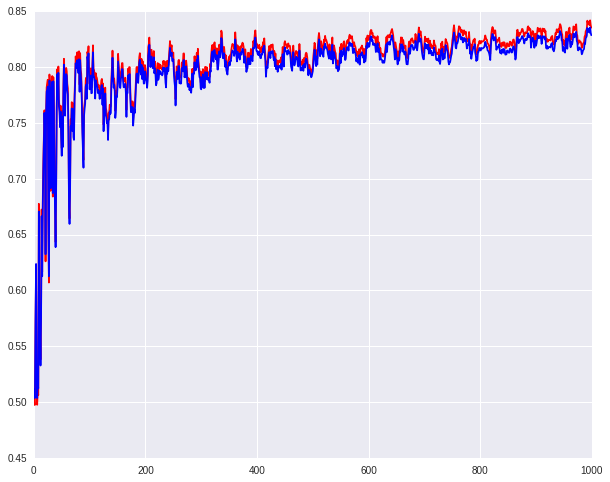

In [53]:
plt.figure(figsize=(10,8))
plt.plot(train_scores, 'r', test_scores, 'b')

## 4. Задание

* Обучим нашу модель **на всех данных**, преобразовав их через ```TfidfVectorizer``` с ```max_features=3000```.

* Параметры модели ```learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3``` и выведем первые 5 самых важных фичей для класса 1 и 5 фичей для класса 0. Убедимся, что они коррелируют с вашей интуицией о хороших/плохих отзывах. 

**Hint:** зная индекс фичи, само слово вы можете получить, используя метод ```vectorizer.get_feature_names()```.

**Hint:** ```np.argsort```.

In [54]:
# Обучите модель
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(review_summaries)
y = train_df.Prediction.values
clf = LogisticRegression()
clf.train(X, y, verbose=True, learning_rate=1.0, num_iters=1000, batch_size=256, reg=1e-3)

iteration 0 / 1000: loss -0.656668
iteration 100 / 1000: loss -0.651467
iteration 200 / 1000: loss -0.535770
iteration 300 / 1000: loss -0.604233
iteration 400 / 1000: loss -0.739136
iteration 500 / 1000: loss -0.710236
iteration 600 / 1000: loss -0.578762
iteration 700 / 1000: loss -0.960785
iteration 800 / 1000: loss -0.918869
iteration 900 / 1000: loss -1.078385


<dmia.classifiers.logistic_regression.LogisticRegression instance at 0x7f895c893b90>

In [55]:
# Получите индексы фичей
pos_features = np.argsort(clf.w)[-50:]
neg_features = np.argsort(clf.w)[:50]

In [56]:
# Выведите слова
fnames = vectorizer.get_feature_names()
print [fnames[p] for p in pos_features]
print [fnames[n] for n in neg_features]

[u'value', u'goodness', u'them', u'than', u'fresh', u'mix', u'find', u'hot', u'outstanding', u'finally', u'super', u'loved', u'food', u'treats', u'smooth', u'free', u'addictive', u'works', u'fabulous', u'and', u'ever', u'wow', u'easy', u'happy', u'treat', u'nice', u'these', u'coffee', u'stuff', u'healthy', u'snack', u'for', u'fantastic', u'my', u'tea', u'perfect', u'amazing', u'tasty', u'loves', u'wonderful', u'favorite', u'yum', u'awesome', u'good', u'yummy', u'excellent', u'delicious', u'love', u'best', u'great']
[u'not', u'disappointed', u'bad', u'too', u'terrible', u'but', u'horrible', u'yuck', u'awful', u'disappointing', u'don', u'stale', u'poor', u'no', u'worst', u'weak', u'beware', u'disgusting', u'taste', u'didn', u'nasty', u'gross', u'like', u'bitter', u'made', u'wrong', u'what', u'is', u'overpriced', u'be', u'off', u'misleading', u'doesn', u'china', u'money', u'in', u'waste', u'tastes', u'ok', u'was', u'much', u'bland', u'do', u'salty', u'disappointment', u'expensive', u'pack

## 5. Сравнение с sklearn.linear_model.LogisticRegression

Обучите такую же модель, но из пакета ```sklearn.linear_model``` и убедитесь, что ваша имплементация ничем не хуже (ну или почти не хуже).

In [57]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score

In [58]:
clf = linear_model.SGDClassifier(n_iter=1000, random_state=42, loss="log", penalty="l2", alpha=1e-3, eta0=1.0, learning_rate="constant")
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=1.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', n_iter=1000, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [59]:
print "Train accuracy = %.3f" % accuracy_score(y_train, clf.predict(X_train))
print "Test accuracy = %.3f" % accuracy_score(y_test, clf.predict(X_test))

Train accuracy = 0.821
Test accuracy = 0.817


# my code (debug)

In [61]:
df = pd.DataFrame(np.random.randn(20,3), columns=('a', 'b', 'c'))

In [43]:
df['a']

0    1.056412
1   -1.417731
Name: a, dtype: float64

In [44]:
a = df['a']

In [46]:
a.value_counts(normalize=True)

 1.056412    0.5
-1.417731    0.5
Name: a, dtype: float64

In [48]:
num_train, dim = X.shape

In [118]:
X = X_train[:10000]

In [122]:
batch_indices = np.random.choice(X_train.shape[0], size=100, replace=True)
batch_indices

array([75245, 26978, 22006, 27404, 44351, 42562, 38721, 60139, 62939,
       35292, 45609, 66673,  4957, 10908, 56744, 27639, 35564, 55111,
       41644,  9517, 70707, 12402, 64086, 56153,  8480,  7829, 17520,
       63227,  2043, 65148, 54482, 32216, 40517, 50526, 76198, 66277,
       35954, 39757, 73091, 46770, 43951, 12829, 35140, 53220, 43944,
       45437, 37879,  9636,   692, 56922, 46492, 17693, 75144, 43492,
        5178, 56607, 61859, 40456, 70698, 66857, 55506,  8865, 22792,
       23774, 31288, 68069, 71264, 33452, 52833, 61247, 45838, 33313,
       71617, 28681, 56584, 37226,  1132, 32506,  9959, 36068, 49081,
       61699, 58532, 29335,  3237, 11889, 40303, 29282, 68813, 27490,
       14304, 76031, 26699,  3868,   586, 48677, 62019,  4438, 14498, 40529])

In [124]:
X_train[batch_indices]

<100x16230 sparse matrix of type '<type 'numpy.float64'>'
	with 368 stored elements in Compressed Sparse Row format>

In [125]:
y_train[batch_indices]

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0])

In [126]:
w = np.random.randn(dim) * 0.01

In [127]:
batch_indices = np.random.choice(X.shape[0], size=10, replace=True)
X_batch = X[batch_indices]
y_batch = y[batch_indices]

In [129]:
X_batch = LogisticRegression.append_biases(X_batch)

In [130]:
X_batch.shape

(10, 16231)

In [134]:
X_batch

<10x16231 sparse matrix of type '<type 'numpy.float64'>'
	with 46 stored elements in Compressed Sparse Row format>

In [140]:
w[:, np.newaxis].transpose().dot(X_batch)

array([[ <10x16230 sparse matrix of type '<type 'numpy.float64'>'
	with 37 stored elements in Compressed Sparse Row format>,
        <10x16230 sparse matrix of type '<type 'numpy.float64'>'
	with 37 stored elements in Compressed Sparse Row format>,
        <10x16230 sparse matrix of type '<type 'numpy.float64'>'
	with 37 stored elements in Compressed Sparse Row format>,
        ...,
        <10x16230 sparse matrix of type '<type 'numpy.float64'>'
	with 37 stored elements in Compressed Sparse Row format>,
        <10x16230 sparse matrix of type '<type 'numpy.float64'>'
	with 37 stored elements in Compressed Sparse Row format>,
        <10x16230 sparse matrix of type '<type 'numpy.float64'>'
	with 37 stored elements in Compressed Sparse Row format>]], dtype=object)

In [135]:
xrow = X_batch[0]

In [136]:
(y_batch + X_batch * w).sum()

ValueError: dimension mismatch

In [147]:
y_batch

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 0])

In [148]:
X_batch * w

array([ 0.00219394, -0.01819983, -0.00462082,  0.00812682, -0.00315007,
        0.00057618,  0.00315497,  0.00394869,  0.00337733, -0.01508833])

In [157]:
xrow = X_batch[0]
y = y_batch[0]

In [158]:
def sigma(xrow):
    return 1.0/(1.0 + np.exp(-1.0 * xrow*w))

In [164]:
loss = -1.0 * (y_batch*np.log(sigma(X_batch)) + (1-y_batch)*(1-np.log(sigma(X_batch)))).sum()

In [165]:
loss

-7.3733133436911453

In [173]:
dw = xrow * (sigma(xrow) - y)

ValueError: dimension mismatch

In [168]:
xrow

<1x16230 sparse matrix of type '<type 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [176]:
dw = (sigma(X_batch) - y_batch) * X_batch

In [178]:
dw[dw > 0]

array([ 0.13552809,  0.24506963,  0.26523555,  0.14014688,  0.27735829,
        0.26650432,  0.17564952,  0.2591412 ,  0.5020317 ,  0.13993756,
        0.4143842 ,  0.36074091,  0.34700833,  0.34912217,  0.25044369,
        0.15197317,  0.28155617,  0.24209267,  0.21669943])

In [181]:
np.sum(w * w) / w.shape[0]

9.9562643266571445e-05

In [184]:
2 * w / w.shape[0]

array([  7.41453263e-07,   2.00747978e-08,  -2.43885506e-06, ...,
        -1.97840652e-06,   1.62338505e-06,  -5.81365052e-07])

In [186]:
w[1:].shape

(16229,)

In [187]:
np.vstack?

In [188]:
a = np.ndarray?

In [192]:
a = np.arange(10).reshape((2,5))
b = np.arange(20).reshape((4,5))

In [196]:
np.vstack((a,b))

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19]])

In [84]:
X
def sigma(xrow):
    return 1.0/(1.0 + np.exp(-1.0 * xrow * w))

y_pos = sigma(X)
y_neg = 1 - sigma(X)
y_proba = np.hstack((y_pos.transpose(), y_neg.transpose()))

ValueError: dimension mismatch

In [220]:
y_proba = np.vstack((y_neg, y_pos)).transpose()

In [212]:
y_pred = y_proba.max(axis=1)

array([ 0.50236076,  0.50349231,  0.50178858, ...,  0.50171363,
        0.50543116,  0.50147207])

In [78]:
def max_by(a, b):
    return int(a > b)

In [79]:
max_by(0.7, 0.5)

1

In [80]:
ufunc = np.frompyfunc(max_by, 2, 1)

In [222]:
ufunc(y_proba[:, 0], y_proba[:, 1])

array([0, 1, 0, ..., 0, 1, 1], dtype=object)

In [223]:
y_proba

array([[ 0.49763924,  0.50236076],
       [ 0.50349231,  0.49650769],
       [ 0.49821142,  0.50178858],
       ..., 
       [ 0.49828637,  0.50171363],
       [ 0.50543116,  0.49456884],
       [ 0.50147207,  0.49852793]])

In [229]:
X = X_batch.copy()

In [232]:
from scipy import sparse
X_biased = sparse.hstack((X, np.ones(X.shape[0])[:, np.newaxis])).tocsr()

In [234]:
X_biased

<1x16231 sparse matrix of type '<type 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

In [235]:
X_biased.toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [236]:
np.ones(X.shape[0])[:, np.newaxis]

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.]])

In [238]:
w.shape

(16230,)

In [240]:
w[:-1].shape

(16229,)

In [144]:
a = np.arange(10).reshape((2,5))

In [145]:
a

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [242]:
X_batch

array([[1, 0, 1, 0, 1],
       [0, 1, 1, 1, 1]])

In [538]:
num_train, dim = X_batch.shape
#w = np.random.randn(dim) * 0.01

def sigma(x):
    return 1.0/(1.0 + np.exp(-1.0 * x.dot(w)))

loss = np.sum(
    y_batch * np.log(sigma(X_batch)) +
    (1 - y_batch) * (1-np.log(sigma(X_batch)))
)
dw = (y_batch - sigma(X_batch)) * X_batch

In [539]:
loss

4.1601117261907907

In [540]:
dw

array([-0.0375542 ,  0.        ,  0.11472613, -0.0375542 , -0.0375542 ])

In [541]:
w = w + dw

In [542]:
w

array([-1.11506892, -0.00595487,  2.15807538, -1.12495567, -1.11633044])

In [445]:
X_batch = sparse.csr_matrix(
    np.random.randint(0, 2, size=(2,5))
)

In [446]:
y_batch = np.array([1,0])

In [447]:
print y_batch
print X_batch

[1 0]
  (0, 2)	1
  (1, 0)	1
  (1, 3)	1
  (1, 4)	1


In [398]:
X_batch = X_train_sample
y_batch = y_train_sample

In [407]:
X_batch

<10x16230 sparse matrix of type '<type 'numpy.float64'>'
	with 38 stored elements in Compressed Sparse Row format>

In [401]:
(y_batch - sigma(X_batch)).dot(X_batch)

ValueError: dimension mismatch

In [408]:
X_batch.dot(w)

array([-0.00734025, -0.0055451 , -0.01520138,  0.00547646, -0.00462014,
       -0.00636778, -0.00385969, -0.00736931, -0.00161101,  0.00602452])

In [411]:
res = y_batch - sigma(X_batch)

In [413]:
res * X_batch

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [414]:
_.shape

(16230,)

In [436]:
from scipy import sparse

In [438]:
sparse.csr_matrix?

In [1]:
import numpy as np

In [2]:
y1 = np.random.randn?

In [4]:
y1 = np.random.randn(2,10)

In [5]:
y1

array([[-1.73133029,  0.68501075, -0.53472462,  0.72073127,  0.05344946,
         1.26096712, -0.89826967,  1.03342978, -1.22183335,  0.12715261],
       [-0.58398588, -0.6210233 ,  1.4349857 ,  0.10247087,  0.28289469,
        -0.0539532 , -0.22368675,  0.30268342,  0.98581703, -1.82215851]])

In [6]:
y1.argmax(axis=0)

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [8]:
1 - _6

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [9]:
_.dtype

dtype('int64')